# Clusterização de Jogadores com Base em Perfil e Desempenho Físico

### Integrantes
Matheus Grandinetti Barbosa Lima

Pedro Henrique Baptista Fernandes

Marcelo Augusto Mrad Marteleto

Pedro Henrique Egito

# 0. Instalação de dependências



In [1]:

!pip install pandas pyarrow matplotlib openpyxl tqdm scikit-learn

## 1. Imports e leitura do arquivo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import json
from sklearn.decomposition import PCA

In [3]:
plt.rcParams["figure.figsize"] = (10, 5)

FILE = Path("Injuries.xlsx")
df = pd.read_excel(FILE)

print(f"Linhas: {len(df):,}")
df.head()

Linhas: 107,971


,Season,Injury,from,until,Days,Games missed,player_name,player_id,url_injuries
0,23/24,Adductor injury,"Jul 10, 2023","Oct 8, 2023",90 days,11,Ricardo Mangas,314944,https://www.transfermarkt.co.uk/ricardo-mangas...
1,20/21,unknown injury,"Apr 7, 2021","Apr 29, 2021",22 days,4,Ricardo Mangas,314944,https://www.transfermarkt.co.uk/ricardo-mangas...
2,18/19,unknown injury,"Apr 26, 2019","May 18, 2019",22 days,2,Lassana Faye,315129,https://www.transfermarkt.co.uk/lassana-faye/v...
3,18/19,Muscle injury,"Apr 11, 2019","Apr 18, 2019",7 days,1,Lassana Faye,315129,https://www.transfermarkt.co.uk/lassana-faye/v...
4,20/21,Ankle surgery,"Dec 16, 2020","Jun 30, 2021",196 days,24,Mink Peeters,315149,https://www.transfermarkt.co.uk/mink-peeters/v...


#  2. Limpeza rápida e colunas auxiliares

In [4]:
df["days_num"] = (
    df["Days"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(float)
)

def season_to_year(s):
    if isinstance(s, str) and "/" in s:
        yy = int(s.split("/")[0])
        return 1900 + yy if yy >= 50 else 2000 + yy
    return pd.NA

df["season_year"] = df["Season"].apply(season_to_year)

df[["Season", "season_year", "days_num"]].head()

,Season,season_year,days_num
0,23/24,2023,90.0
1,20/21,2020,22.0
2,18/19,2018,22.0
3,18/19,2018,7.0
4,20/21,2020,196.0


# 3. Top-10 tipos de lesão mais frequentes

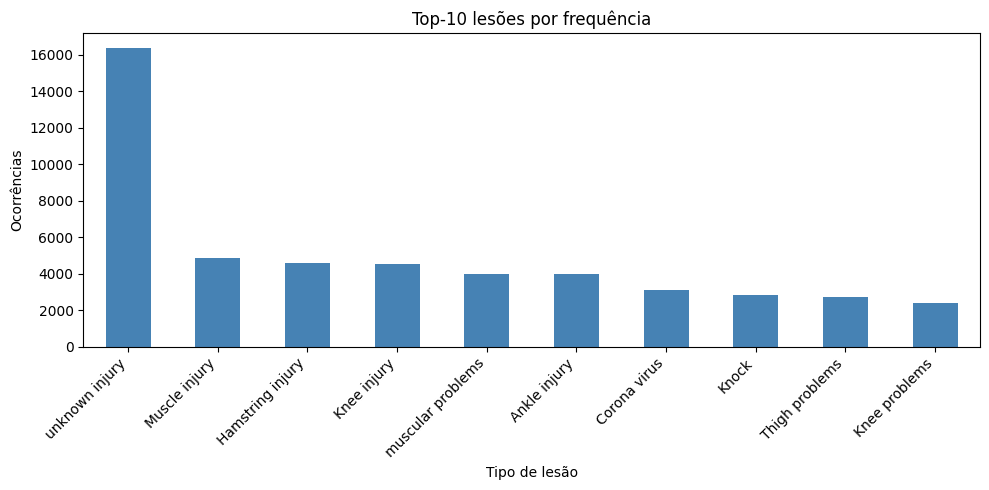

In [5]:
top10 = df["Injury"].value_counts().head(10)
top10.plot(kind="bar", color="steelblue")
plt.title("Top-10 lesões por frequência")
plt.xlabel("Tipo de lesão")
plt.ylabel("Ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 4. Lesões com maior média de dias afastado  
### (considerando apenas tipos com ≥ 20 ocorrências)

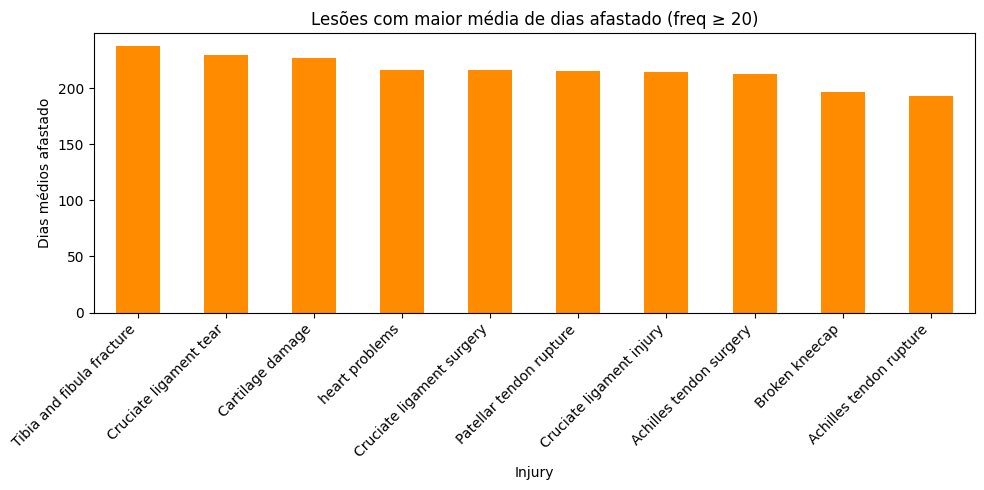

In [6]:
severe = (
    df.groupby("Injury")
    .agg(freq=("Injury", "size"), mean_days=("days_num", "mean"))
    .query("freq >= 20")
    .sort_values("mean_days", ascending=False)
    .head(10)
)

severe["mean_days"].plot(kind="bar", color="darkorange")
plt.title("Lesões com maior média de dias afastado (freq ≥ 20)")
plt.ylabel("Dias médios afastado")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

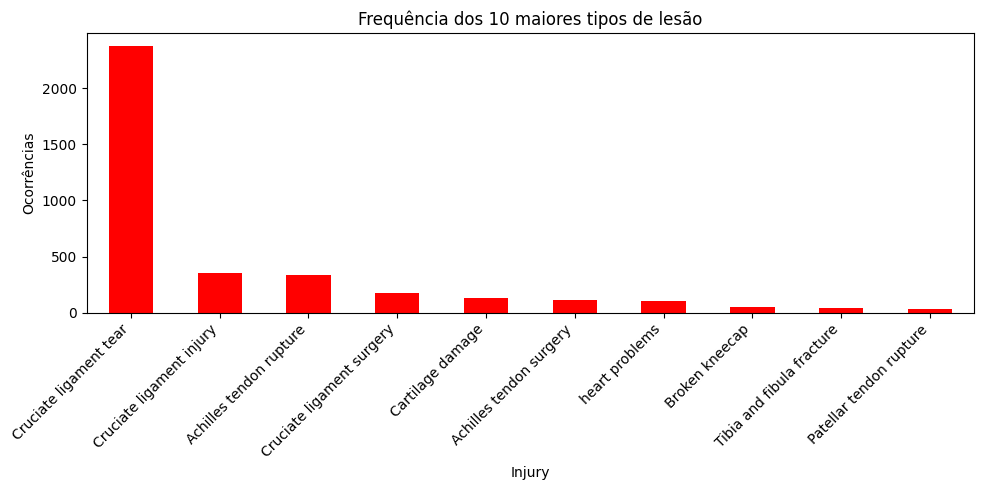

In [7]:
severe.sort_values(by=["freq"], ascending=False)["freq"].plot(kind="bar", color="red")
plt.title("Frequência dos 10 maiores tipos de lesão")
plt.ylabel("Ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

É interessante perceber que mesmo possuindo maior média de dias afastados, fraturas de tíbia e fíbula possuem números de ocorrência bem menores que outros tipos de lesão, com destaque para ruptura do ligamento cruzado, que possui frequência e dias de afastamento altos.

# 5. Evolução de registros por temporada (2000-2023)

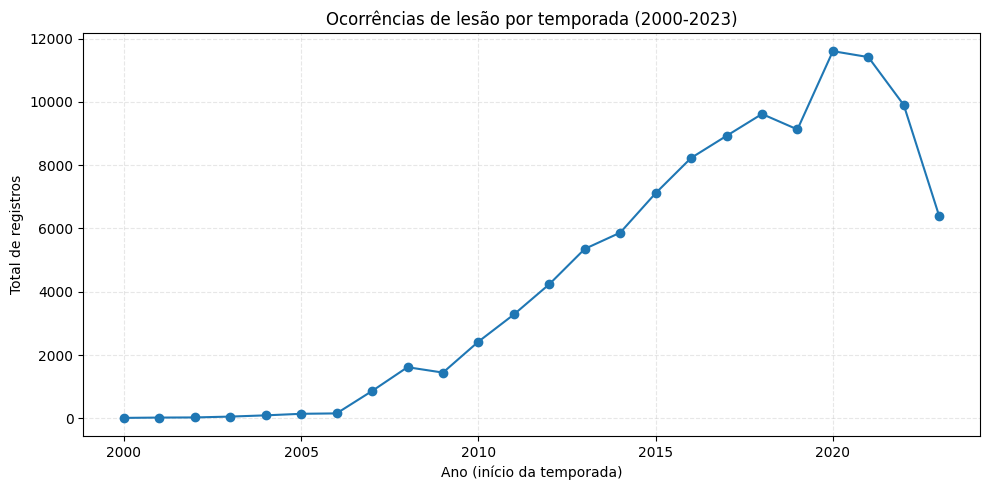

In [8]:
trend = (
    df[df["season_year"].between(2000, 2023)]
    .groupby("season_year")["Injury"]
    .count()
)

trend.plot(marker="o")
plt.title("Ocorrências de lesão por temporada (2000-2023)")
plt.xlabel("Ano (início da temporada)")
plt.ylabel("Total de registros")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

O comportamento ascendente do total de registros pode significar várias coisas: um aumento de competitividade e esforço nas temporadas, o que implica em maior frequência de lesões. Melhora na coleta de dados, com técnicas mais refinadas e democratizadas.

# 6. Distribuição de dias afastado

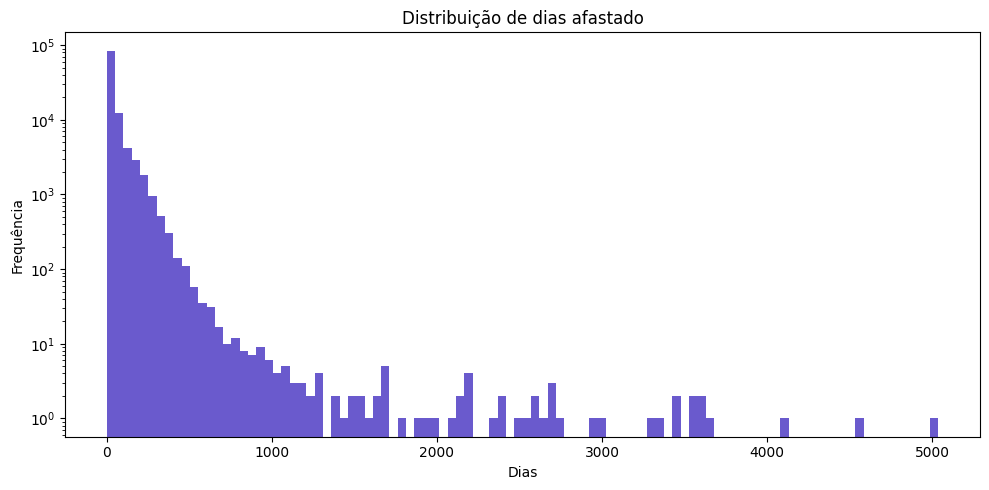

In [9]:
df["days_num"] = pd.to_numeric(df["days_num"], errors="coerce")
df["days_num"].dropna().plot(kind="hist", bins=100, color="slateblue")
plt.yscale("log")
plt.title("Distribuição de dias afastado")
plt.xlabel("Dias")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

A frequência de lesões com menos dias de afastamento é muito mais expressiva que a de longos períodos, o que faz sentido, já que grande parte das lesões envolvem traumas pequenos e pontuais.

# Observações iniciais
- Unknown/Muscle/Hamstring/Knee dominam em frequência.
- Fraturas e rupturas ligamentares lideram em média de dias fora (> 200).
- Crescente número de registros após 2010, pico em 2020-21 (prováveis efeitos de Covid/relato).
- Distribuição de dias é assimétrica – longa cauda de casos severos.
- Esses achados alimentam nossas futuras etapas:
- Selecionar rótulos de severidade (> 90 dias) para modelos de risco.
- Combinar com métricas físicas para detectar clusters de alto risco.

# 7. Enriquecendo com scraping dinâmico (Transfermarkt)
 - Pegaremos lesões **atuais** na La Liga
- Baixaremos histórico recente (últimas 3 temporadas) para cada jogador
- Geraremos novas métricas de risco
 - Uniremos ao `df` original

In [16]:
from scraper.transfermarkt_scraper import (
    get_league_injuries,
    get_team_player_urls,
    get_player_injury_history,
    get_multiple_players_injury_history,
)
from tqdm import tqdm
import requests, time

sess = requests.Session()

In [17]:
# ### 7.1 Jogadores da temporada 23/24 no Injuries.xlsx

# %%
# 'Season' e 'player_name' vêm do Injuries.xlsx
players_23 = (
    df[df["Season"] == "23/24"]["player_name"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Jogadores únicos em 23/24 no Injuries.xlsx: {len(players_23)}")

Jogadores únicos em 23/24 no Injuries.xlsx: 4103


In [18]:
# ------------------------------------------------------------------
# 7.2 Scraping liga → tabela de lesionados hoje
# ------------------------------------------------------------------
today_laliga = get_league_injuries(country_name="Spain", session=sess)
today_laliga.head()

,Team,Injury Type,Expected Return,Market Value (€),Player,Position
0,NaN,Appendicitis,NaN,€28.00m,Ferran Torres Centre-Forward,<NA>
1,Ferran Torres,NaN,NaN,NaN,NaN,<NA>
2,Centre-Forward,NaN,NaN,NaN,NaN,<NA>
3,NaN,Lymphatic cancer,NaN,€12.00m,Kirian Rodríguez Attacking Midfield,<NA>
4,Kirian Rodríguez,NaN,NaN,NaN,NaN,<NA>


In [19]:
# %%
# ------------------------------------------------------------------
# 7.3 Para cada time da La Liga, coletar histórico de todos os jogadores
#    (limitado a 3 temporadas para ser rápido)
# ------------------------------------------------------------------
team_urls = {
    # slug Transfermarkt → url (adicione se precisar)
    "FC Barcelona": "https://www.transfermarkt.com/fc-barcelona/startseite/verein/131",
    "Real Madrid":  "https://www.transfermarkt.com/real-madrid/startseite/verein/418",
    # ...
}

frames = []
for club, url in tqdm(team_urls.items(), desc="Times"):
    player_urls = get_team_player_urls(url, session=sess, pause=1.0)
    hist = get_multiple_players_injury_history(player_urls, session=sess, pause=1.2)
    hist["Club"] = club
    frames.append(hist)

hist_all = pd.concat(frames, ignore_index=True)
print(f"Histórico baixado: {len(hist_all):,} linhas")

Times:   0%|          | 0/2 [00:00<?, ?it/s]

[WARN] falhou em https://www.transfermarkt.com/gerard-martin/profil/spieler/705395: Histórico de lesões não encontrado.
[WARN] falhou em https://www.transfermarkt.com/mikayil-faye/profil/spieler/666974: Histórico de lesões não encontrado.
[WARN] falhou em https://www.transfermarkt.com/pau-victor/profil/spieler/707572: Histórico de lesões não encontrado.


Times:  50%|█████     | 1/2 [01:06<01:06, 66.88s/it]

[WARN] falhou em https://www.transfermarkt.com/fran-gonzalez/profil/spieler/1055220: Histórico de lesões não encontrado.
[WARN] falhou em https://www.transfermarkt.com/raul-asencio/profil/spieler/935245: Histórico de lesões não encontrado.


Times: 100%|██████████| 2/2 [02:07<00:00, 63.63s/it]

Histórico baixado: 534 linhas


In [20]:
print(hist_all.columns.tolist())

['Player', 'Season', 'Injury', 'from', 'until', 'Days Missed', 'Games Missed', 'Profile URL', 'Club']


In [21]:
# ### 7.4 Limpeza e agregação das últimas 3 temporadas
if "from" in hist_all.columns:
    hist_all.rename(columns={"from": "Start"}, inplace=True)
# %%
# Extrai número de dias
hist_all["Days Missed"] = (
    hist_all["Days Missed"].astype(str).str.extract(r"(\d+)").astype(float)
)
# Converte data
hist_all["Start"] = pd.to_datetime(hist_all["Start"], errors="coerce")
hist_all["season_year"] = hist_all["Start"].dt.year

# Filtra últimas 3 temporadas (>=2021)
recent = hist_all.query("season_year >= 2021")

agg = (
    recent.groupby("Player")
    .agg(
        total_days_3y=("Days Missed", "sum"),
        n_events_3y=("Injury", "size"),
        most_common_injury=("Injury", lambda s: s.value_counts().idxmax()),
    )
    .reset_index()
)

# Métricas de severidade
agg["severity_idx"] = (
    agg["total_days_3y"] / agg["n_events_3y"].replace(0, pd.NA)
).fillna(0)
agg["high_risk_flag"] = (
    (agg["total_days_3y"] > 60) | (agg["n_events_3y"] >= 3)
)

# Renomeia para mesclar
agg.rename(columns={"Player": "player_name"}, inplace=True)
agg.head()

,player_name,total_days_3y,n_events_3y,most_common_injury,severity_idx,high_risk_flag
0,#10AnsuFati,347.0,9,Fitness,38.555556,True
1,#10LukaModrić,69.0,9,Thigh problems,7.666667,True
2,#11Raphinha,76.0,4,Muscle injury,19.000000,True
3,#11Rodrygo,110.0,12,Rest,9.166667,True
4,#13AndriyLunin,65.0,7,Corona virus,9.285714,True


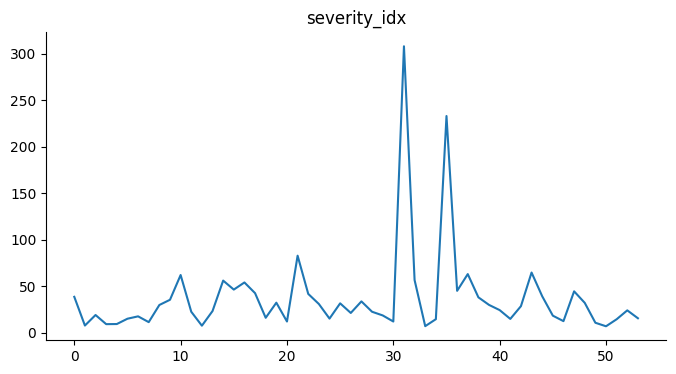

In [22]:
# @title severity_idx

from matplotlib import pyplot as plt
agg['severity_idx'].plot(kind='line', figsize=(8, 4), title='severity_idx')
plt.gca().spines[['top', 'right']].set_visible(False)

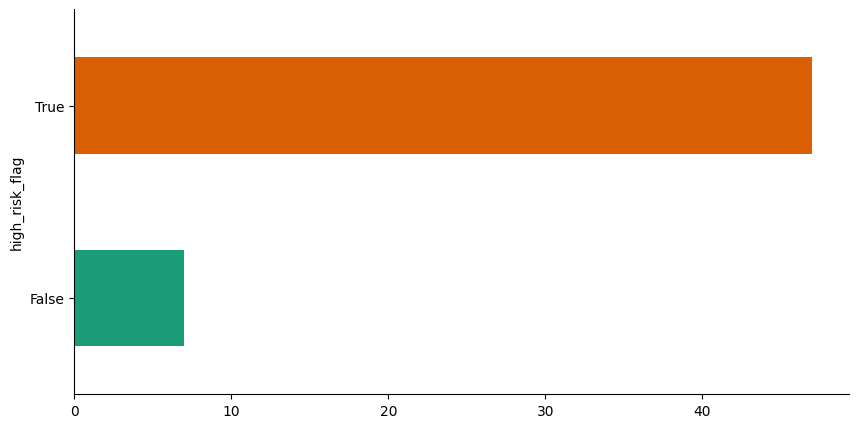

In [23]:
# @title high_risk_flag

from matplotlib import pyplot as plt
import seaborn as sns
agg.groupby('high_risk_flag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Criação de métricas de risco
- severity_idx = total_days_3y / n_events_3y (0 quando não há eventos).
- high_risk_flag = True se total_days_3y > 60 ou n_events_3y ≥ 3.

In [24]:
# ### 7.5 Mesclagem das métricas de risco no df original

# %%
enriched_df = df.merge(agg, on="player_name", how="left")

# Preenche valores faltantes
for col in ["total_days_3y", "n_events_3y", "severity_idx"]:
    enriched_df[col] = enriched_df[col].fillna(0)
enriched_df["high_risk_flag"] = enriched_df["high_risk_flag"].fillna(False)

print("Shape final:", enriched_df.shape)
enriched_df.head()

Shape final: (107971, 16)


/tmp/ipykernel_12699/935217856.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enriched_df["high_risk_flag"] = enriched_df["high_risk_flag"].fillna(False)


,Season,Injury,from,until,Days,Games missed,player_name,player_id,url_injuries,days_num,season_year,total_days_3y,n_events_3y,most_common_injury,severity_idx,high_risk_flag
0,23/24,Adductor injury,"Jul 10, 2023","Oct 8, 2023",90 days,11,Ricardo Mangas,314944,https://www.transfermarkt.co.uk/ricardo-mangas...,90.0,2023,0.0,0.0,NaN,0.0,False
1,20/21,unknown injury,"Apr 7, 2021","Apr 29, 2021",22 days,4,Ricardo Mangas,314944,https://www.transfermarkt.co.uk/ricardo-mangas...,22.0,2020,0.0,0.0,NaN,0.0,False
2,18/19,unknown injury,"Apr 26, 2019","May 18, 2019",22 days,2,Lassana Faye,315129,https://www.transfermarkt.co.uk/lassana-faye/v...,22.0,2018,0.0,0.0,NaN,0.0,False
3,18/19,Muscle injury,"Apr 11, 2019","Apr 18, 2019",7 days,1,Lassana Faye,315129,https://www.transfermarkt.co.uk/lassana-faye/v...,7.0,2018,0.0,0.0,NaN,0.0,False
4,20/21,Ankle surgery,"Dec 16, 2020","Jun 30, 2021",196 days,24,Mink Peeters,315149,https://www.transfermarkt.co.uk/mink-peeters/v...,196.0,2020,0.0,0.0,NaN,0.0,False


In [25]:
# ------------------------------------------------------------------
# 7.6 Salvar para uso em modelagem / clusterização
# ------------------------------------------------------------------
enriched_df.to_csv("injuries_enriched_laliga23.csv", index=False)
print("Arquivo salvo: injuries_enriched_laliga23.csv")

Arquivo salvo: injuries_enriched_laliga23.csv


* total_days_3y   = soma dos dias perdidos nos últimos 3 anos  
* n_events_3y     = número de ocorrências de lesão  
* most_common_injury = tipo de lesão mais frequente


– Unimos essas métricas ao df inicial (via player_name), preenchendo zeros/Falses onde faltavam dados.

# Dados de Tracking

## Ler Arquivo e descobrir o Frame Rate

In [26]:
# Load the file line by line
with open("12844.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

frames = []

for frame in data:
    frame_num = frame.get("frameNum")
    period = frame.get("period")
    time = frame.get("videoTimeMs")

    # Combine both teams
    for team, players in [('home', frame.get("homePlayers", [])),
                          ('away', frame.get("awayPlayers", []))]:
        for p in players:
            frames.append({
                "frame": frame_num,
                "period": period,
                "time_ms": time,
                "team": team,
                "jersey": p.get("jerseyNum"),
                "x": p.get("x"),
                "y": p.get("y"),
                "speed": p.get("speed")
            })

df = pd.DataFrame(frames)
df.dropna(subset=["jersey", "x", "y"], inplace=True)

df = df.sort_values(by=["team", "jersey", "frame"])

df["dx"] = df.groupby(["team", "jersey"])["x"].diff()
df["dy"] = df.groupby(["team", "jersey"])["y"].diff()
df["distance"] = (df["dx"]**2 + df["dy"]**2)**0.5

performance = df.groupby(["team", "jersey"]).agg(
    total_distance=("distance", "sum"),
    avg_speed=("speed", "mean"),
    max_speed=("speed", "max"),
    n_frames=("frame", "count")
).reset_index()

## Análise básica e clusterização em uma partida

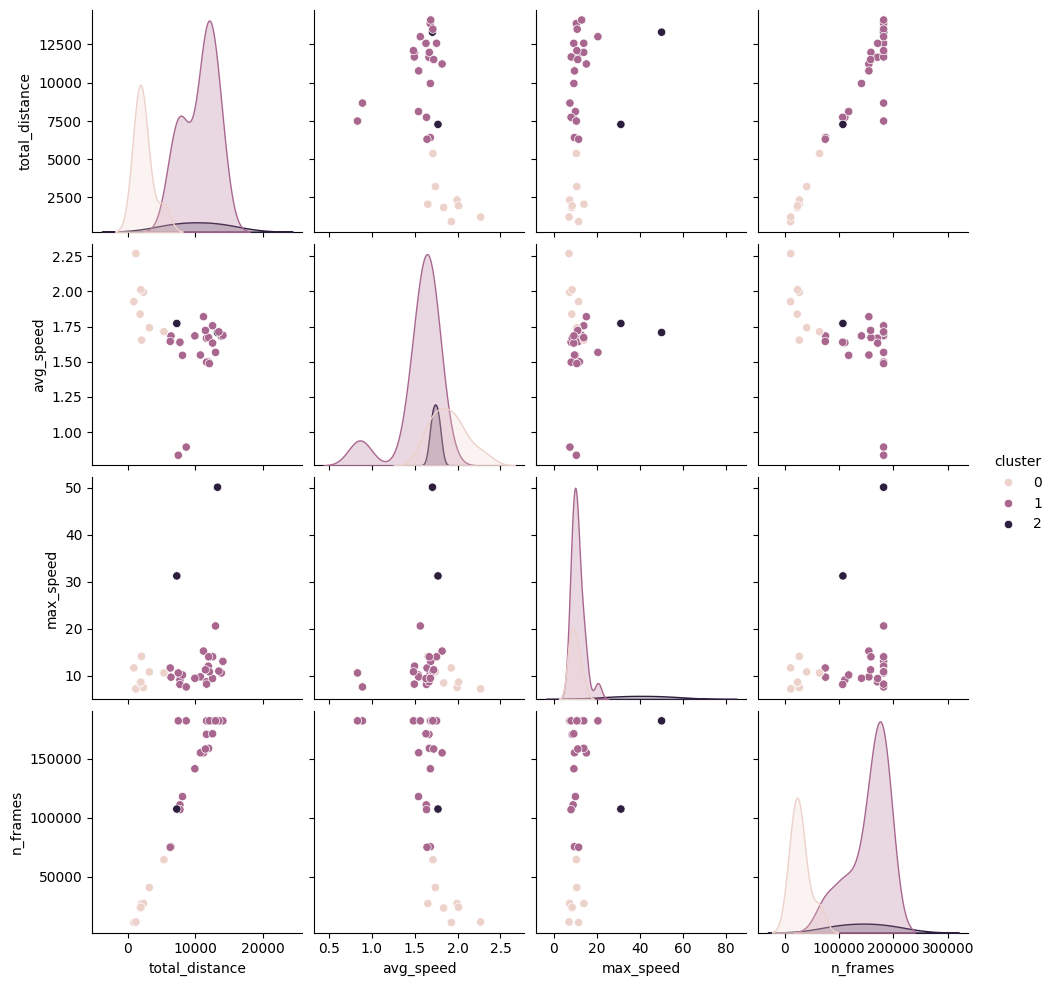

In [27]:
X = performance[["total_distance", "avg_speed", "max_speed"]]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
performance["cluster"] = kmeans.fit_predict(X_scaled)

sns.pairplot(performance, hue="cluster", diag_kind="kde")
plt.show()

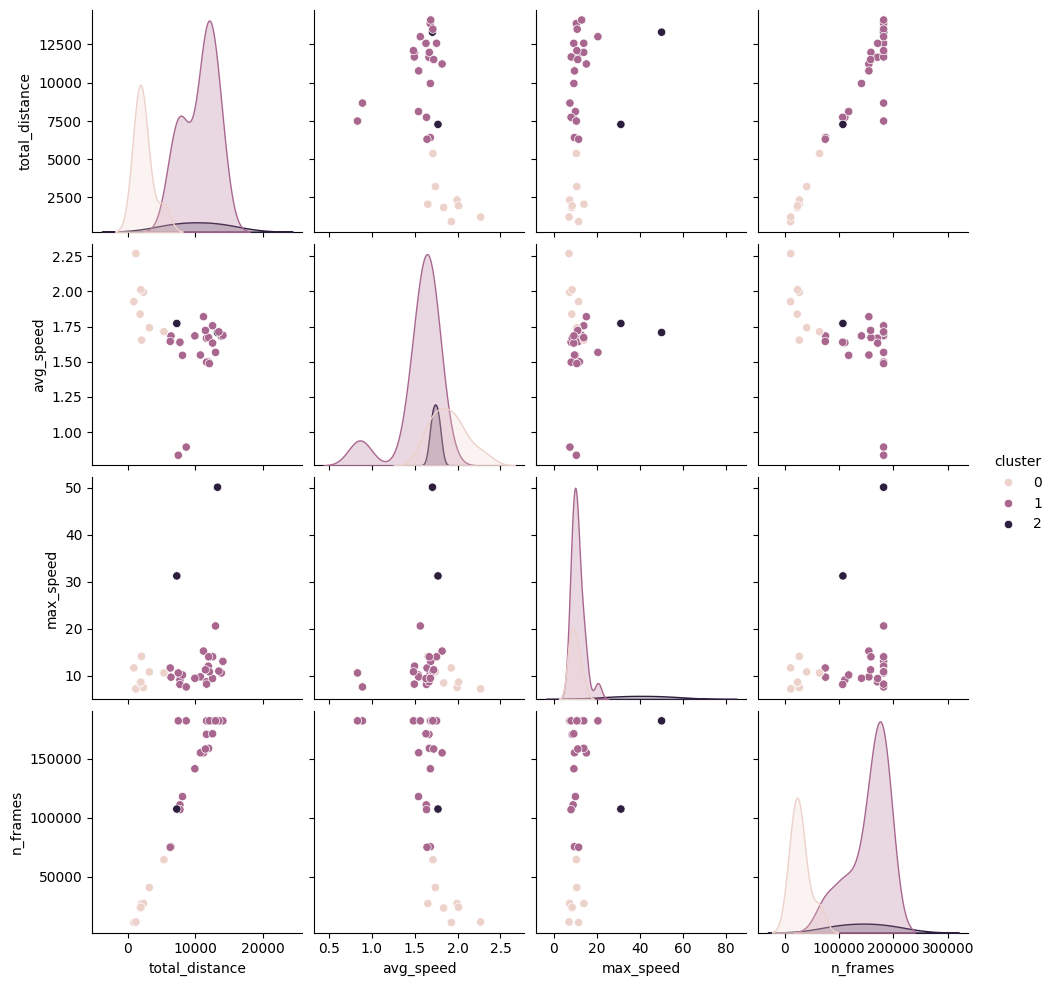

In [28]:
X = performance[["total_distance", "avg_speed", "max_speed"]]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
performance["cluster"] = kmeans.fit_predict(X_scaled)

sns.pairplot(performance, hue="cluster", diag_kind="kde")
plt.show()

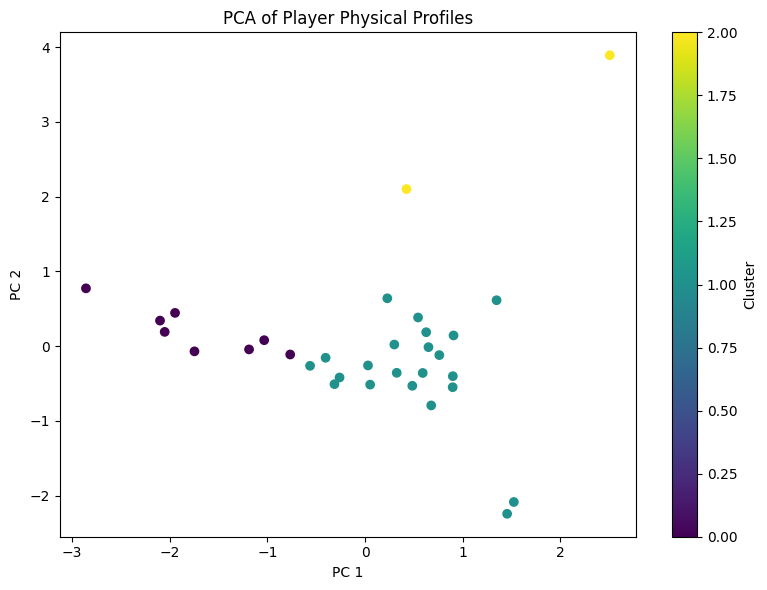

In [29]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=performance["cluster"], cmap="viridis")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of Player Physical Profiles")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()